In [197]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('notebook')

In [198]:
import sys
sys.path.append('../')
import targprop.operations as ops

## define the model 

*(using model notation)*

-----------

$$ h_1 = W_1 x_0\quad\quad x_1 = \operatorname{tanh}(h_1)\quad\quad x_2 = W_2x_1$$

where
$$x_0\in\mathbb{R}^{n_0}, h_1\in\mathbb{R}^{n_1}, x_1\in\mathbb{R}^{n_1}, x_2\in\mathbb{R}^{n_2}$$

In [170]:
# dimensions
n0 = 1 # input dimension / number of input units
n1 = 2 # hidden dimension / number of hidden layer units
n2 = 1  # output dimension

# weights
#W1 = np.random.randn(n1, n0) # input to hidden. n1 x n0 iid Guassian
#W2 = np.random.randn(n2, n1) # hidden to output. n2 x n1 iid Gaussian

th1 = 3*np.pi/8
W1 = np.array([[np.cos(th1)], [np.sin(th1)]]) # size 2 x 1
th2 = -2*np.pi/8
W2 = np.array([[np.cos(th2) , np.sin(th2)]]) # size 1 x 2

# inputs
num_examples = 51

x0 = np.linspace(-3, 3, num_examples)[np.newaxis, :]

#x0 = 0.75*np.random.randn(n0, num_examples) # n0 x num_examples matrix

# x0 = np.meshgrid(np.linspace(-1, 1, num_examples), np.linspace(-1, 1, num_examples))
# x0 = np.stack((x0[0].flatten(), x0[1].flatten()), axis=0)
# num_examples = num_examples**2

## define operations

In [171]:
lin = ops.linear()
tanh = ops.tanh()

## forward pass on model

In [172]:
# forward pass on the model
h1 = lin.f( W1, x0 )
x1 = tanh.f( h1 )
x2 = lin.f( W2, x1 )

## train model

In [173]:
#W1_est = np.random.randn(n1, n0) # initialization of W1

num_steps = 1

h1_est = num_steps*[None]
x1_est = num_steps*[None]
x2_est = num_steps*[None]

loss = num_steps*[None]

x1_tar = num_steps*[None]
h1_tar = num_steps*[None]
W1_est = num_steps*[None]

x1_d = num_steps*[None]
h1_d = num_steps*[None]
W1_d = num_steps*[None]

#W2_est = num_steps*[None]

th3 = 1*np.pi/8
W1_est[0] = np.array([[np.cos(th3)], [np.sin(th3)]])
alpha=1.

#W2_est[0] = np.copy(W2)

for t in range(num_steps):
  # forward
  h1_est[t] = lin.f( W1_est[t], x0 )
  x1_est[t] = tanh.f( h1_est[t] )
  x2_est[t] = lin.f( W2, x1_est[t] )
  loss[t] = 0.5*np.mean((x2_est[t] - x2)**2)

  # backward:
  x1_tar[t] = lin.f_rinv( x2.T, x1_est[t].T, W2.T , gamma=1e-12).T
  h1_tar[t] = tanh.f_rinv( x1_tar[t], h1_est[t], gamma=1e-12 )
  
  # backward derivatives
  x1_d[t] = lin.df( x2_est[t].T - x2.T, h1_est[t].T, W2.T ).T
  h1_d[t] = tanh.df( x1_d[t], h1_est[t] )
  W1_d[t] = lin.df( h1_d[t], W1_est[t], x0 )
  
  W1p = lin.f_inv( h1_tar[t], W1_est[t], x0 )
  if t<num_steps-1:
    W1_est[t+1] = W1_est[t] - alpha*(W1_est[t] - W1p)
      
#   # grad descent
#   if t<num_steps-1:
#     W1_est[t+1] = W1_est[t] - alpha*(W1_d[t])
      
#   W2p = lin.f_inv( x2, W2_est[t], x1_est[t] ) # update W2 based on old x1 *or* x1_target?, i.e update W2 based on the ideal x1 or actual x1
#   if t<num_steps-1:
#     W2_est[t+1] = W2[t] - alpha*(W2[t] - W2p)
  

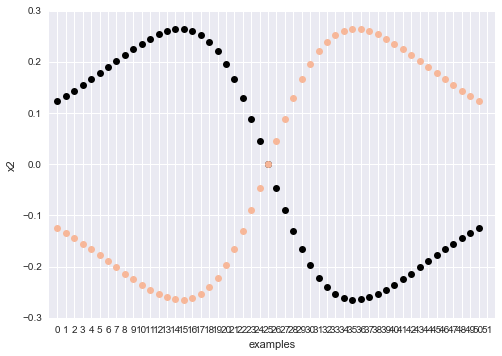

data=blue, estimates=green


In [174]:
sns.set_palette(sns.color_palette("RdBu", num_steps+1))
f = plt.plot(x2.T,'ko')[0]
for t in range(num_steps):
  plt.plot(x2_est[t].T,'o')
plt.xlim([-1, num_examples+1])
f.axes.xaxis.set_ticks(np.arange(0, num_examples+1))
plt.xlabel('examples')
plt.ylabel('x2')
plt.show()
print "data=blue, estimates=green"

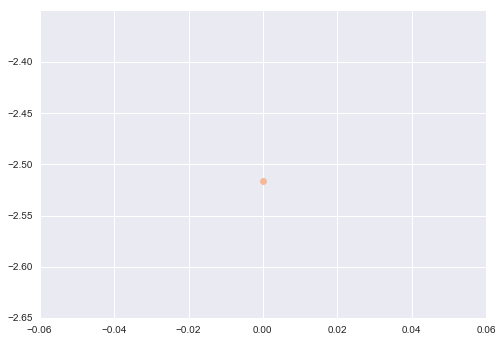

In [175]:
plt.plot(np.log(loss),'o-')

### visualize learning

In [209]:
cmap = sns.color_palette("coolwarm", num_examples)
sort_inds = np.argsort(x2[0])

In [210]:
cmap_sorted = [cmap[i] for i in np.argsort(sort_inds)]

In [211]:
def axify(ax, lims=None):
  ax.axis('equal')
  if not lims:
    lims = ax.get_xlim() + ax.get_ylim()
    lims = min(lims), max(lims)
  ax.set_xlim(lims)
  ax.set_ylim(lims)

  ax.xaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 0.5))
  ax.yaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 0.5))
  
  ax.hlines([0], *ax.get_xlim(), linewidth=0.75, alpha=0.5)
  ax.vlines([0], *ax.get_ylim(), linewidth=0.75, alpha=0.5)


In [212]:
def add_scatterplot(fig, nrows, ncols, subplot, data, args):
  
  if data.shape[0]==1:
    rng = data.max() - data.min()
    ax = fig.add_subplot(nrows, ncols, subplot)
    #ax.scatter(data[0,:], rng*0.0*(np.random.rand(1, data.shape[1])-0.5), **args)
    ax.scatter(data[0,:], np.linspace(-0.05, 0.05, data.shape[1]), **args)
    axify(ax)
    ax.set_xlim((data.min()-rng*0.1, data.max()+rng*0.1))
    ax.set_ylim((-rng*0.1, rng*0.1))
    ax.yaxis.set_ticks([0])

  elif data.shape[0]==2:
    ax = fig.add_subplot(nrows, ncols, subplot)
    ax.scatter(data[0,:], data[1,:], **args)
    axify(ax)
  elif data.shape[0]>2:
    ax = fig.add_subplot(nrows, ncols, subplot, projection='3d')
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

In [213]:
def append_scatterplot(ax, data, args):

  if data.shape[0]==1:
    ax.scatter(data[0,:], np.zeros_like(data), **args)
  elif data.shape[0]==2:
    ax.scatter(data[0,:], data[1,:], **args)
  elif data.shape[0]>2:
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

In [214]:
def get_subspaces(A, r):
  u,s,v = np.linalg.svd(A, full_matrices=True)
  ss = {'im': u[:,:r], 'ker': v[r:].T, 'coim': v[:r].T, 'coker': u[:,r:]}
  return ss

In [215]:
W2_ss = get_subspaces(W2, 1)
ker_line = np.dot(W2_ss['ker'], np.linspace(-5, 5, 201)[np.newaxis, :])
ker_lines = ker_line[:,:,np.newaxis] + np.dot(np.linalg.pinv(W2), x2)[:,np.newaxis,:]

In [216]:
h1_lines = tanh.f_inv(ker_lines, 0, 1e-15)

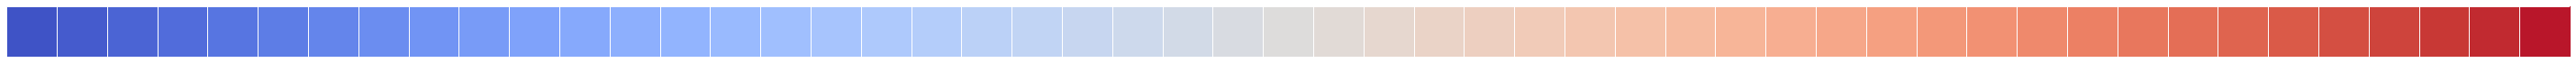

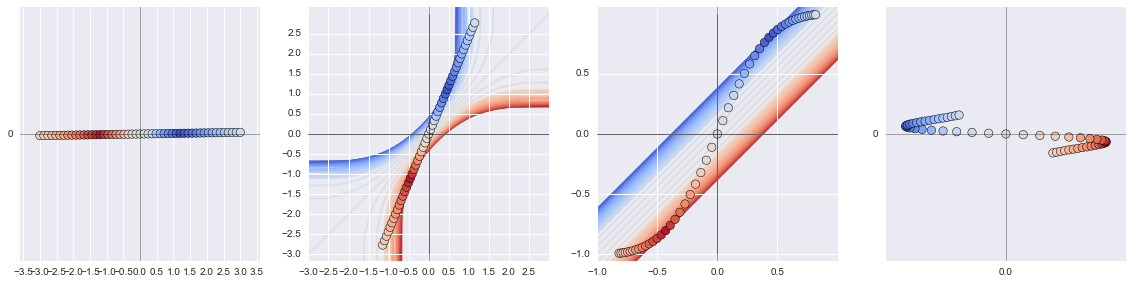

In [218]:
sns.palplot(cmap)

rows = min(num_steps+1, 6)
cols = 5
mult = 5

fig = plt.figure(figsize=(mult*cols, mult*rows))

args = {}
args['c'] = cmap_sorted
args['s'] = 70
args['linewidth'] = 0.5

args2 = {}
args2['c'] = cmap_sorted
args2['s'] = 30
args2['linewidth'] = 2
args2['marker'] = 'x'

args3 = {}
args3['c'] = cmap_sorted
args3['s'] = 30
args3['linewidth'] = 1
args3['marker'] = 'v'

ax = []

# plot inputs
i = 0
ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

i=1
ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))
#ax.append(fig.add_subplot(rows, cols, i+1))
for j in np.arange(0, num_examples, 1):
  ax[-1].plot(h1_lines[0,:,j], h1_lines[1,:,j], c=cmap_sorted[j], linewidth=2, alpha=0.75, zorder=0)
axify(ax[-1], [-3,3])
#ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))
#ax[-1].contour
#append_scatterplot(ax[-1], h1_target, args3)

# plot ker_lines
i=2
ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))
#ax.append(fig.add_subplot(rows, cols, i+1))
for j in np.arange(0, num_examples, 1):
  ax[-1].plot(ker_lines[0,:,j], ker_lines[1,:,j], c=cmap_sorted[j], linewidth=2, alpha=0.75, zorder=0)
axify(ax[-1], [-1,1])
  
#ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))
#append_scatterplot(ax[-1], x1_target, args3)

# plot outputs
i=3
ax.append(add_scatterplot(fig, rows, cols, i+1, x2, args))

# for t in range(rows-1):
#   i = (t+1)*cols+0
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

#   i=(t+1)*cols+1
#   ax.append(add_scatterplot(fig, rows, cols, i+1, h1_est[t], args))
#   append_scatterplot(ax[-1], h1_tar[t], args2)
#   append_scatterplot(ax[-1], h1_est[t] + h1_d[t], args3)

#   i=(t+1)*cols+2
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x1_est[t], args))
#   append_scatterplot(ax[-1], x1_tar[t], args2)
#   append_scatterplot(ax[-1], x1_est[t] + x1_d[t], args3)
  
#   i=(t+1)*cols+3
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t], args))

#   i=(t+1)*cols+4
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t] - x2, args))
  
# # print "W1=\n", W1
# # print "\nW2=\n", W2
# # print "\nW1 initial guess = \n", W1_est[-1]


In [224]:
print "W1=\n", W1
print "\nW2=\n", W2

W1=
[[ 0.38268343]
 [ 0.92387953]]

W2=
[[ 0.70710678 -0.70710678]]


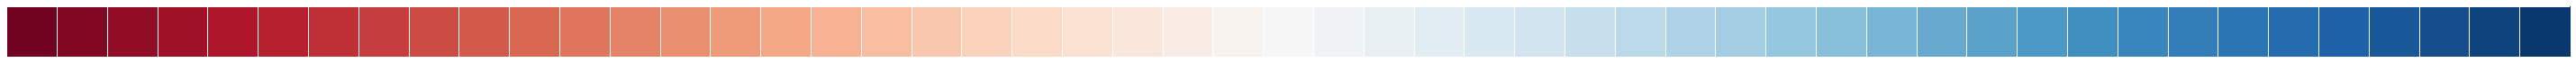

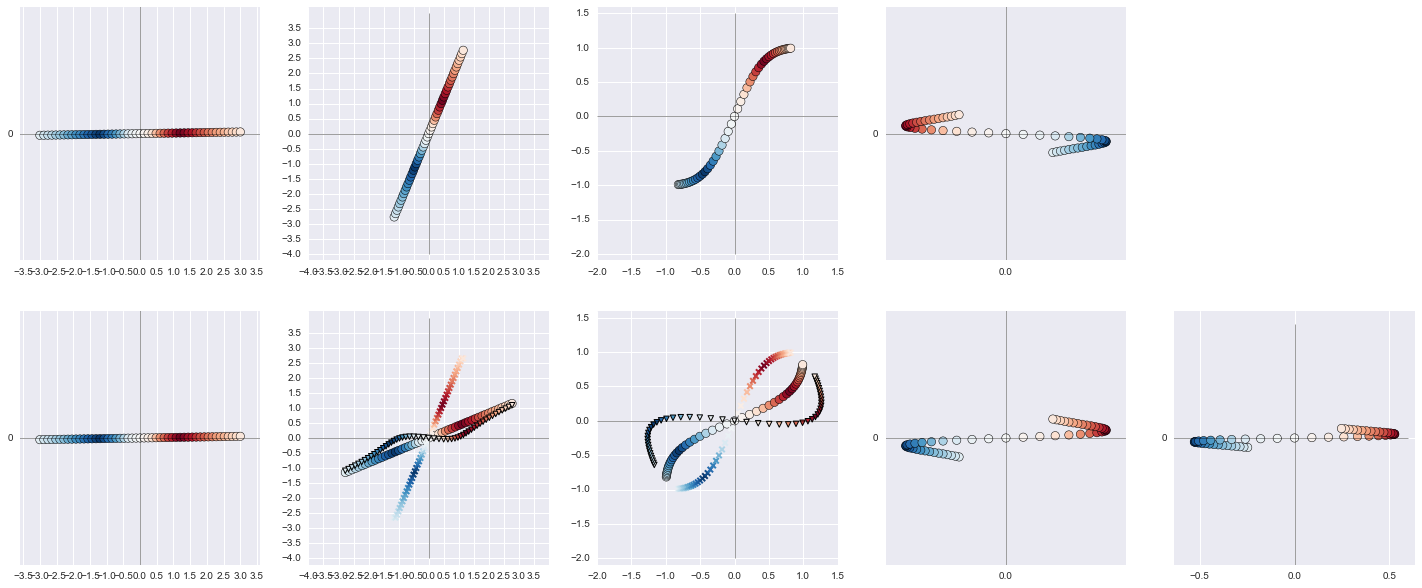

In [185]:
sns.palplot(cmap)

rows = min(num_steps+1, 6)
cols = 5
mult = 5

fig = plt.figure(figsize=(mult*cols, mult*rows))

args = {}
args['c'] = cmap_sorted
args['s'] = 70
args['linewidth'] = 0.5

args2 = {}
args2['c'] = cmap_sorted
args2['s'] = 30
args2['linewidth'] = 2
args2['marker'] = 'x'

args3 = {}
args3['c'] = cmap_sorted
args3['s'] = 30
args3['linewidth'] = 1
args3['marker'] = 'v'

ax = []

i = 0
ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

i=1
ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))
#ax[-1].contour
#append_scatterplot(ax[-1], h1_target, args3)

i=2
ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))
#append_scatterplot(ax[-1], x1_target, args3)

i=3
ax.append(add_scatterplot(fig, rows, cols, i+1, x2, args))

for t in range(rows-1):
  i = (t+1)*cols+0
  ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

  i=(t+1)*cols+1
  ax.append(add_scatterplot(fig, rows, cols, i+1, h1_est[t], args))
  append_scatterplot(ax[-1], h1_tar[t], args2)
  append_scatterplot(ax[-1], h1_est[t] + h1_d[t], args3)

  i=(t+1)*cols+2
  ax.append(add_scatterplot(fig, rows, cols, i+1, x1_est[t], args))
  append_scatterplot(ax[-1], x1_tar[t], args2)
  append_scatterplot(ax[-1], x1_est[t] + x1_d[t], args3)
  
  i=(t+1)*cols+3
  ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t], args))

  i=(t+1)*cols+4
  ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t] - x2, args))
  
# print "W1=\n", W1
# print "\nW2=\n", W2
# print "\nW1 initial guess = \n", W1_est[-1]


In [67]:
np.eye(2) - np.dot(np.linalg.pinv(W2), W2)

array([[ 0.5,  0.5],
       [ 0.5,  0.5]])

Toy example.

Input dimension: 1. One-dimensional inputs shown in column 1 plotted vertically.

Hidden dimension: 2. $h_1$ and $x_1$ plotted in column 2 and 3.

Output dimension: 1. One-dimensional outputs shown in column 4 plotted horizontally.

First row. Model that generates $x_2$ outputs, where $W_1=[-1\;\; -4]^\top$ and $W_2=[-1\;\; -1]$:

$$x_0 \quad\rightarrow\quad h_1 = W_1x_0 \quad\rightarrow\quad x_1=tanh(h_1) \quad\rightarrow\quad x_2=W_2x_1$$

Second row (circles). Everything is known except $W_1$. We start with an initial random estimate of $W_1$, which we specify as, say, $\tilde{W}_1 = [-3\;\; 1]$

$$x_0 \quad\rightarrow\quad \tilde{h}_1 = \tilde{W}_1x_0 \quad\rightarrow\quad \tilde{x}_1=tanh(\tilde{h}_1) \quad\rightarrow\quad \tilde{x}_2=W_2\tilde{x}_1$$

Note that the final output $\tilde{x}_2\neq x_2$. In particular, the color of the dots are in the wrong orientation.

Second row (triangles). We then invert the true output $x_2$ backward to create targets. E.g. if we look at row 2, column 3. The red target is in the preimage of the red $x_2$ (row 1, column 4) through the $W_2=[1\;\;0]$ linear function. We choose the red target $\hat{x}_2$ that is in the preimage, and is closest to the current $\tilde{x}_2$. We then invert the targets through $\operatorname{tanh}^{-1}$ again to get the triangles in row 2 column 2. We use these targets to get a new $W_1$. 

Third row (circles). Using the newly trained $W_1$, we propagate forward and find that the new $x_2$ matches the real $x_2$.

-----------

Note: This example is a bit trivial. What is a good minimally nontrivial toy example? One triviality of the above example: The target propagation scheme of choosing an element in the preimage closest to the current activation *does not* help in training. We could have assigned $x_1$ targets (row 2, col 3) by $\hat{x}_1 = W_2^\dagger x_2$ instead of offsetting each point. What is a good example where our target assignment approach is necessary for training?

In [225]:
# plot W1 loss...
wa, wb = np.meshgrid(np.linspace(-3,3,500), np.linspace(-3,3,500))

In [226]:
l_grid = np.zeros_like(wa)
for i in range(wa.shape[0]):
  for j in range(wa.shape[0]):
    l_grid[i,j] = 0.5*np.mean((np.dot( W2, np.tanh( np.dot( np.array([[wa[i,j]], [wb[i,j]]]), x0 ) ) ) - x2)**2)


(-3.0, 3.0, -3.0, 3.0)

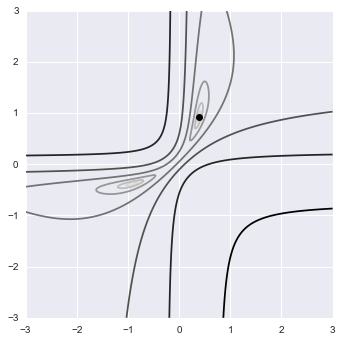

In [228]:
plt.contour(wa, wb, np.log(l_grid), 10)
#for i in range(len(W1_est)):
#  plt.plot(W1_est[i][0], W1_est[i][1],'ro')
plt.plot(W1[0], W1[1],'ko')
plt.axis('square')

In [26]:
def plot3d_lines(ax):
  args = {'linewidth':0.5, 'alpha':0.5}
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  zlim = ax.get_zlim()
  for i in range(3):
    ax.plot([0,0], [0,0], [-zlim, zlim], 'k', **args)
    ax.plot([0,0], [-ylim, ylim], [0,0], 'k', **args)
    ax.plot([-xlim, xlim], [0,0], [0,0], 'k', **args)


In [ ]:
def get_subspaces(A_, r):
    ''' return: a dict containing the four fundamental subspaces of a matrix A '''
    u,s,v = np.linalg.svd(A_, full_matrices=True)
    ss = {'im': u[:,:r], 'ker': v[r:].T, 'coim': v[:r].T, 'coker': u[:,r:]}
    return ss

def plot_vecline(V, i=0, color=0):
    ''' plots the 1d subspace (line) spanned by one vector V '''
    VV = np.concatenate((-10*V, 10*V), axis=1)
    ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=2.0)
    
def plot_quotient(V, W, i=0, color=5):
    ''' plots elements (lines) of the quotient space V/W 
        todo: replace n with sv or 1/sv
    '''
    for n in np.arange(-3,3.1,0.5):
        VV = np.concatenate((-10*V, 10*V), axis=1)
        VV = VV + n*W
        ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=0.5)

def square_axes(i=0):
    ''' make axis look nice '''
    fig.axes[i].axhline(0, color='w', linewidth=3.5)
    fig.axes[i].axvline(0, color='w', linewidth=3.5)
    fig.axes[i].set_xlim(-3.5,3.5)
    fig.axes[i].set_ylim(-3.5,3.5)
    fig.axes[i].set_aspect(1)
    fig.axes[i].get_xaxis().set_ticklabels([])
    fig.axes[i].get_yaxis().set_ticklabels([])